## MODELLING TANZANIA WATER POINTS

### Data pre-processing

I will drop some columns that have no meaningfull information to the model. I will also convert our target variable from strings of (functional, non functional, functional needs repair) to 0,1 and 2 values in order to make our model. I will import my cleaned data from my EDA notebook for the purpose of modelling. This will help in reducing run time for my modelling purpose. 

In [51]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, train_test_split
import category_encoders as ce
from sklearn.metrics import classification_report
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier




I will import the libraries to use for my modelling

Importing my EDA notebook

In [45]:
from ipynb.fs.full.EDA import *

In [3]:
df.head()

,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,construction_year_bins
0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,"(1990, 2000]"
1,1399,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,"(2000, 2010]"
2,686,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,"(2000, 2010]"
3,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,"(1980, 1990]"
4,0,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,"(1990, 2000]"


I will create a copy of the cleaned data df from the EDA notebook so as to maintain the cleaned data as it is.

In [4]:
#create a copy of the clean df
clean_df = df.copy()

In [5]:
clean_df.head()

,gps_height,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,construction_year_bins
0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,functional,"(1990, 2000]"
1,1399,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,"(2000, 2010]"
2,686,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,"(2000, 2010]"
3,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,"(1980, 1990]"
4,0,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,"(1990, 2000]"


#### Converting Target variable to numerical variables of 0,1,2

We need to convert our target variable from strings of (functional, non functional, functional needs repair) to 0,1 and 2 values in order to make our model

In [6]:
target_variable = {'functional':0, 
                   'non functional': 2, 
                   'functional needs repair': 1} 
clean_df['status_group'] = clean_df['status_group'].replace(target_variable)

In [7]:
clean_df['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

- 0 = functional water points ,

- 2 = non-functinal water point

- 1 = functional but needs repair water points,



I will drop Iga and ward columns since we have region column with similar information

In [8]:
#drop Iga and ward columns since we have region column with similar information
clean_df.drop(columns=['lga','ward'],inplace=True ) 

#### converting boolean type column of true or false values to 0 and 1

In [9]:
#convert True/False in permit column to 0-1(boolean to int)
clean_df['permit'] =clean_df['permit'].astype(bool).astype(int) 

In [10]:
#convert True/False in public meeting column to 0-1(boolean to int)
clean_df['public_meeting'] = clean_df['public_meeting'].astype(bool).astype(int)

#### Dividing all the features in categorical and numerical features and give them variables

I will divide my features into two categories i.e `numerical_variables` to be scaled using scaler and `categorical_variables` to be  encoded using encoder

In [11]:
# numerical features placed in a variable 
numerical_variables = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit'] 

In [12]:
# categorical features placed in a variable  
categorical_variables = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','construction_year_bins']

### Converting Target Ternary classes to Target Binary classes

I will convert my target variable from having three classes to having two classes. I will combine functional water points with water points that are functional needs repair as 1. I will make non functional water points to be 0

In [13]:
# convert ternary classes to binary class
status_group_dict = {0:1, 1: 1, 2 : 0}
clean_df['status_group'] = clean_df['status_group'].replace(status_group_dict )

In [14]:
#print the status group value count
clean_df['status_group'].value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

Now we have two categories to be predicted(binary)
- 1 = functional water points ,

- 0 = non-functinal water point




### Making Pipeline

Dividing the data into x(predictive_features) and y(target feature)

In [15]:
# create the target variable and the predictors in form of x and y
y = clean_df['status_group']
X = clean_df.drop('status_group', axis=1)



Dividing the data into training and testing data

In [16]:
# to divide our X and y to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### MODEL 1: Logistic Regression Model with TargetEncoder and RobustScaler()

Predictive features that are categorical need to be encoded to int. For this model i will use TargetEncoder since most of my categorical data has many categories thus target encoder encode the categories into int by replacing them for a measurement of the effect they might have on the target.
There is also need to standardize the numerical features. I will use RobustScaler which uses Interquatile range to remove outliers and standadize my data. 

In [17]:
# Giving the robustScaler and TargetEncoder a variable.
scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=categorical_variables)

The make_pipeline function will be automatically applied scaler, encoder, and our model to the pipe in order to fit it very easily.

In [18]:
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

In [19]:
# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, numerical_variables),
                    ('cat', cat_transformer, categorical_variables)])


In [20]:
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

In [21]:
# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.7640572390572391
TEST: 0.7692760942760942

Balanced Accuracy:
TRAIN: 0.7418625912097385
TEST: 0.7463425907968401


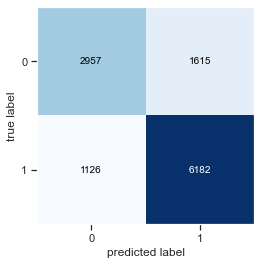

In [22]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

The confusion matrix above shows that 1126 water points were misclassified as non-functional water points instead of functional waterpoints. Also, 1615 water points were misclassified as functional water points instead of non-functional water points. 

Now, I will take the roc_auc score with doing LogReg with cross validation to compare With other model results. I choose cv as 5, since it gives 5 different results for each trial and gets their mean as the cross_val_score. Cross_val_score gives more accurate results. I will be using both of them just to see the difference. 

In [23]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean()) 

0.8251027405196286


Instead of train-test splits, I prefer cross validation which is more accurate. It splits the train-test 5 times and finds the mean. Observation -It takes more time than train-test split.

I will create a dataFrame to store the results of all the models for easy comparison. creating an empty dataframe to write our results on it to keep when parameters and models changed.

In [24]:
# an empty data frmae to see all results
df_results = pd.DataFrame(columns=["Model", "Scaler",'Encoder',
                                   'roc_auc score ']) 

In [25]:
df_results = df_results.append({       
     "Model": 'LogReg_1' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'TargetEncoder',
               'roc_auc score ' :0.8251027405196286
                    }, ignore_index=True)

In [26]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103


### MODEL 2: Logistic Regression Model with OneHot Encoder and MinMaxScaler()

For my second model I will be changing the scaler and encoder just to make a comparison of the best scaler and encoder to use for this problrm.

In [27]:
scaler = MinMaxScaler()
encoder = ce.OneHotEncoder(cols=categorical_variables)

In [28]:
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, numerical_variables),
                    ('cat', cat_transformer, categorical_variables)])


# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.784006734006734
TEST: 0.7821548821548822

Balanced Accuracy:
TRAIN: 0.7682344673545355
TEST: 0.7651629753177405


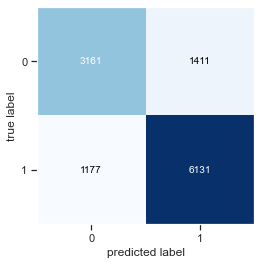

In [29]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

In [30]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(),)

0.8469125878894046


In [31]:
df_results = df_results.append({       
     "Model": 'LogReg_2' ,
      "Scaler": 'MinMaxScaler()' , 
       'Encoder' : 'OneHotEncoder',
               'roc_auc score ' :0.8469125878894046
                    }, ignore_index=True)

In [32]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103
1,LogReg_2,MinMaxScaler(),OneHotEncoder,0.846913


From our dataFrame above one-hot encoder gives the best value for roc_auc score. One-hot encoder though it gives the best results it takes to much time to run the model.

### MODEL 3: Decision Tree Classifier

For this model i will be trying a new model just to try and improve the roc-auc score from the logistic regression. To improve the score i will try Decision Tree Classifier first.
 

In [33]:
# define a decision tre with parametere.
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                            random_state=42, class_weight='balanced')

In [34]:
pipe = make_pipeline(preprocessor,dt)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.7698863636363636
TEST: 0.7661616161616162

Balanced Accuracy:
TRAIN: 0.7145385876935693
TEST: 0.7109337625900211


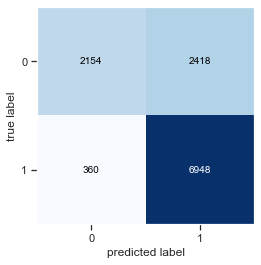

In [35]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

In [36]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean())

0.7633377108064654


In [37]:
df_results = df_results.append({       
     "Model": 'DecisionTree' ,
      "Scaler": 'MinMaxScaler()' , 
       'Encoder' : 'OneHotEncoder',
               'roc_auc score ' :0.7633377108064654
                    }, ignore_index=True)

In [38]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103
1,LogReg_2,MinMaxScaler(),OneHotEncoder,0.846913
2,DecisionTree,MinMaxScaler(),OneHotEncoder,0.763338


Decision Tree Classifier reduced the roc_auc score from 84% to 76%.

### MODEL 4: RandomForest Classifier

I will change the model again to try and see if RandomForest Classifier works well for this problem as compared to both Logistics classifier and Decision Tree classifier.
Random forest models can reduce overfitting risk by randomness as building n_estimators, bootstrapping sample and splitting nodes on the best split among a random subset of the features selected at every node and converting non-homogeneous node into best possibles. 

In [39]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,class_weight='balanced')

In [40]:
pipe = make_pipeline(preprocessor,rf)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")



Accuracy:
TRAIN: 0.9982112794612794
TEST: 0.8552188552188552

Balanced Accuracy:
TRAIN: 0.998083918215908
TEST: 0.8402721211572691


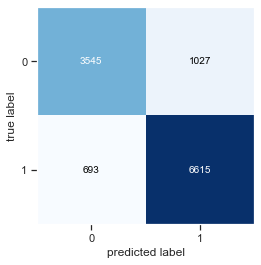

In [41]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
plot_confusion_matrix(cm)
plt.show()

In [42]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean())

0.9168410558868798


In [43]:
df_results = df_results.append({       
     "Model": 'RandomForest' ,
      "Scaler": 'MinMaxScaler()' , 
       'Encoder' : 'OneHotEncoder',
               'roc_auc score ' :0.9168410558868798
                    }, ignore_index=True)

In [44]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103
1,LogReg_2,MinMaxScaler(),OneHotEncoder,0.846913
2,DecisionTree,MinMaxScaler(),OneHotEncoder,0.763338
3,RandomForest,MinMaxScaler(),OneHotEncoder,0.916841


 Random forest model gives the best reults so far of 91 %. 

### MODEL 5: K-NearestNeighbors  Classifier

I will try K-NearestNeighbors Classifier as my last model before tuning my best model of the 5 models. 
The general principle of k-Neighbors is to find closest in distance of the new point to predefined number of training points and predict the label according to this. First we tried this model without any parameter tuning.

In [52]:
knn = KNeighborsClassifier(metric='manhattan', n_neighbors=5, weights='distance')

In [53]:
pipe = make_pipeline(preprocessor,knn)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.9985690235690236
TEST: 0.8402356902356902

Balanced Accuracy:
TRAIN: 0.9983434055247851
TEST: 0.823344280240832


In [55]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean())

0.8990328312963299


In [58]:
df_results = df_results.append({       
     "Model": 'KNN' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'OneHotEncoder',
               'roc_auc score ' :0.8990328312963299
                    }, ignore_index=True)

In [ ]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103
1,LogReg_2,MinMaxScaler(),OneHotEncoder,0.846913
2,DecisionTree,MinMaxScaler(),OneHotEncoder,0.763338
3,RandomForest,MinMaxScaler(),OneHotEncoder,0.916841
5,KNN,Robust,OneHotEncoder,0.899033


KNN is not better than the Random Forest model in terms of roc_auc score.Also, it is not efficient as it takes to much time to run the model since for this problem has so many preditive features to work with. 

### Hyperparameter tuning For The Random Forest Model using Grid search 

#### comparing results

In [75]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103
1,LogReg_2,MinMaxScaler(),OneHotEncoder,0.846913
2,DecisionTree,MinMaxScaler(),OneHotEncoder,0.763338
3,RandomForest,MinMaxScaler(),OneHotEncoder,0.916841
5,KNN,Robust,OneHotEncoder,0.899033


I created a dataFrame to store the model, scaler used,encoder used and ROC_AUC SCORE results of each model. According to the results dataFrame the best performing model For this binary problem was Random Forest classifier. I will therefore carry out parameter tuning for this model to come up with the best parameters for this model.

Since Random forest performed better than the other four models, i will carry out Hyperparameter tuning for the model to choose the best parameters for the model. I will also use OneHotEncoder to encode my categorical features and also use MinMaxScaler() to scale my numerical features. Grid search shows us the best parameters for model. 

### BEST MODEL: RandomForest Classifier 2

In [90]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs = -1,class_weight='balanced')

In [91]:
# fit the model
final_model = make_pipeline(preprocessor,rf)
final_model.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_pred_test = pipe.predict(X_test)

print("Accuracy:")
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

print("\nBalanced Accuracy:")
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")

Accuracy:
TRAIN: 0.998442760942761
TEST: 0.8541245791245792

Balanced Accuracy:
TRAIN: 0.998354322793721
TEST: 0.8384409922897569


In [92]:
# Replace None with appropriate code
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss

preds = final_model.predict(X_test)
probs = final_model.predict_proba(X_test)


print("log loss: ", log_loss(y_test, probs))
print("accuracy: ", accuracy_score(y_test, y_pred_test))
print("precision:", precision_score(y_test, y_pred_test))
print("recall:   ", recall_score(y_test, y_pred_test))

log loss:  0.4928232623987876
accuracy:  0.8541245791245792
precision: 0.8631921824104235
recall:    0.9065407772304324


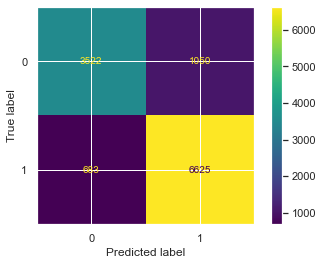

In [87]:
#plot_confusion_matrix(lr, y_test, y_pred_test)
plot_confusion_matrix(pipe, X_test, y_test)  
plt.show()

In [80]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean())

0.9182835754645484


In [81]:
df_results = df_results.append({       
     "Model": 'RandomForest' ,
      "Scaler": 'MinMaxScaler()' , 
       'Encoder' : 'OneHotEncoder',
               'roc_auc score ' :0.9182835754645484
                    }, ignore_index=True)

In [82]:
df_results

,Model,Scaler,Encoder,roc_auc score
0,LogReg_1,Robust,TargetEncoder,0.825103
1,LogReg_2,MinMaxScaler(),OneHotEncoder,0.846913
2,DecisionTree,MinMaxScaler(),OneHotEncoder,0.763338
3,RandomForest,MinMaxScaler(),OneHotEncoder,0.916841
4,KNN,Robust,OneHotEncoder,0.899033
5,RandomForest,MinMaxScaler(),OneHotEncoder,0.918284


Tuning our model by increasing n_estimators from 50 to 100 slightly increased the accuracy of the model from 0. 916841 to 0.918284. From the confusion matrxi 6625 water points were correctly classified as functional while 683 water points were wrongly classified as Non-functional but were actually funtional water points. Also, 3522 Water points correctly classified as non-functional while 1050 water points were wrongly classiied as functional but were actually non-functional water points.